In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [9]:
sns.set(style="whitegrid", context="talk")


In [3]:
DATA_PATH = "data/"

column_names = (
    ["engine_id", "cycle",
     "op_setting_1", "op_setting_2", "op_setting_3"]
    + [f"sensor_{i}" for i in range(1, 22)]
)

train_df = pd.read_csv(
    DATA_PATH + "train_FD001.txt",
    sep=r"\s+",
    header=None,
    names=column_names,
    engine="python"
)

test_df = pd.read_csv(
    DATA_PATH + "test_FD001.txt",
    sep=r"\s+",
    header=None,
    names=column_names,
    engine="python"
)

rul_df = pd.read_csv(
    DATA_PATH + "RUL_FD001.txt",
    header=None,
    names=["RUL"]
)

# Drop accidental NaNs from parsing
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Train engines:", train_df["engine_id"].nunique())
print("Test engines:", test_df["engine_id"].nunique())
print("RUL entries:", len(rul_df))


Train engines: 100
Test engines: 100
RUL entries: 100


In [4]:
train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [11]:
max_cycles = train_df.groupby("engine_id")["cycle"].max()

train_df["RUL"] = train_df.apply(
    lambda row: max_cycles[row["engine_id"]] - row["cycle"],
    axis=1
)

MAX_RUL = 125
train_df["RUL"] = train_df["RUL"].clip(upper=MAX_RUL)


In [12]:
drop_sensors = [
    "sensor_1", "sensor_5", "sensor_6",
    "sensor_10", "sensor_16", "sensor_18", "sensor_19"
]

train_df.drop(columns=drop_sensors, inplace=True)
test_df.drop(columns=drop_sensors, inplace=True)


In [13]:
feature_cols = [
    col for col in train_df.columns
    if col not in ["engine_id", "cycle", "RUL"]
]


In [14]:
scaler = MinMaxScaler()

train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])


In [15]:
def create_train_sequences(df, seq_len=30):
    X, y = [], []

    for engine_id in df["engine_id"].unique():
        engine_data = df[df["engine_id"] == engine_id].sort_values("cycle")
        features = engine_data[feature_cols].values
        labels = engine_data["RUL"].values

        for i in range(len(features) - seq_len):
            X.append(features[i:i+seq_len])
            y.append(labels[i+seq_len-1])

    return np.array(X), np.array(y)


In [16]:
SEQ_LEN = 30
X_train, y_train = create_train_sequences(train_df, SEQ_LEN)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: (17631, 30, 17)
y_train: (17631,)


In [18]:
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 6095.7271 - val_loss: 5581.9009
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4332.3223 - val_loss: 4176.9556
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3277.1128 - val_loss: 3238.5530
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2596.3613 - val_loss: 2623.9004
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2178.8662 - val_loss: 2243.3201
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1943.2228 - val_loss: 2017.3706
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1820.6664 - val_loss: 1895.2622
Epoch 8/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1767.9244 - val_loss: 1831.3809
Epoch 9/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1747.9832 - val_loss: 1801.1609
Epoch 10/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1741.3009 - val_loss: 1784.9229
Epoch 11/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1584.42

In [20]:
def create_test_sequences(df, seq_len=30):
    X = []

    for engine_id in sorted(df["engine_id"].unique()):
        engine_data = df[df["engine_id"] == engine_id].sort_values("cycle")
        features = engine_data[feature_cols].values

        if len(features) >= seq_len:
            seq = features[-seq_len:]
        else:
            pad = np.zeros((seq_len - len(features), features.shape[1]))
            seq = np.vstack((pad, features))

        X.append(seq)

    return np.array(X)


In [21]:
X_test = create_test_sequences(test_df, SEQ_LEN)
print("X_test:", X_test.shape)


X_test: (100, 30, 17)


In [22]:
y_pred = model.predict(X_test).flatten()
y_pred = np.clip(y_pred, 0, MAX_RUL)

print("NaNs in prediction:", np.isnan(y_pred).sum())


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
NaNs in prediction: 0


In [23]:
rmse = np.sqrt(mean_squared_error(rul_df["RUL"], y_pred))
print("RMSE:", rmse)


RMSE: 16.956479182875697


In [24]:
health_percent = (y_pred / MAX_RUL) * 100

def health_zone(h):
    if h > 70:
        return "Healthy"
    elif h > 30:
        return "Warning"
    else:
        return "Critical"


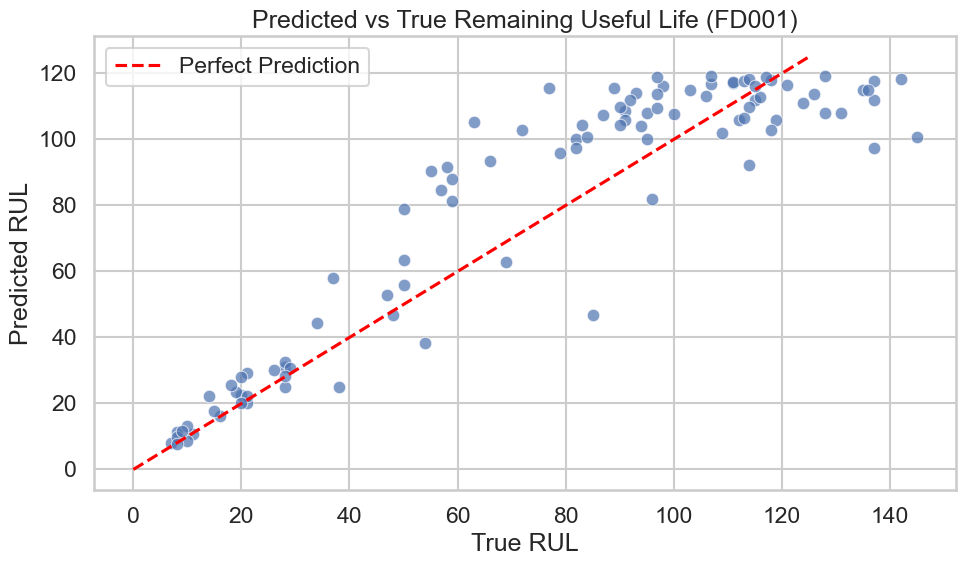

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=rul_df["RUL"],
    y=y_pred,
    alpha=0.7
)

plt.plot(
    [0, MAX_RUL],
    [0, MAX_RUL],
    color="red",
    linestyle="--",
    label="Perfect Prediction"
)

plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs True Remaining Useful Life (FD001)")
plt.legend()
plt.tight_layout()
plt.show()


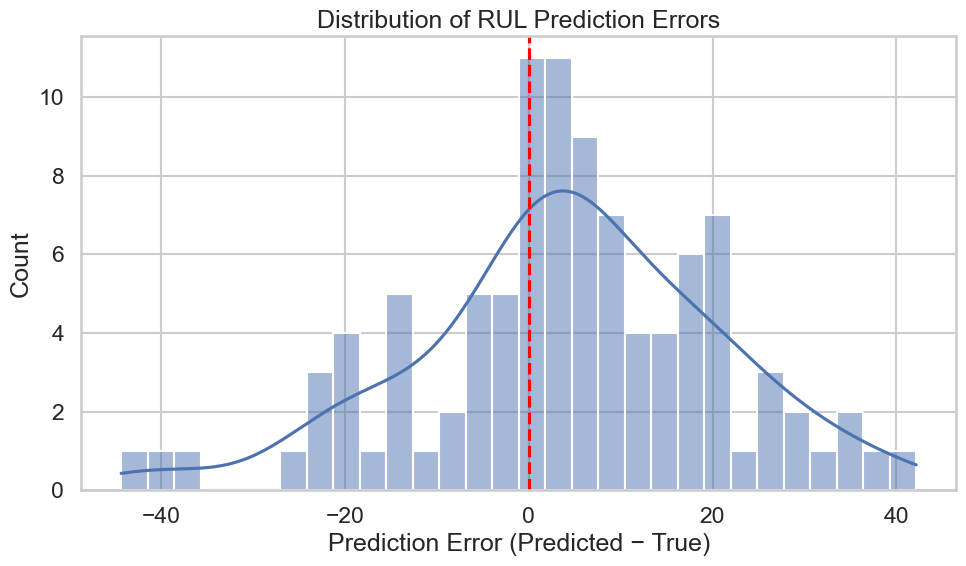

In [26]:
errors = y_pred - rul_df["RUL"]

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)

plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Prediction Error (Predicted − True)")
plt.title("Distribution of RUL Prediction Errors")
plt.tight_layout()
plt.show()


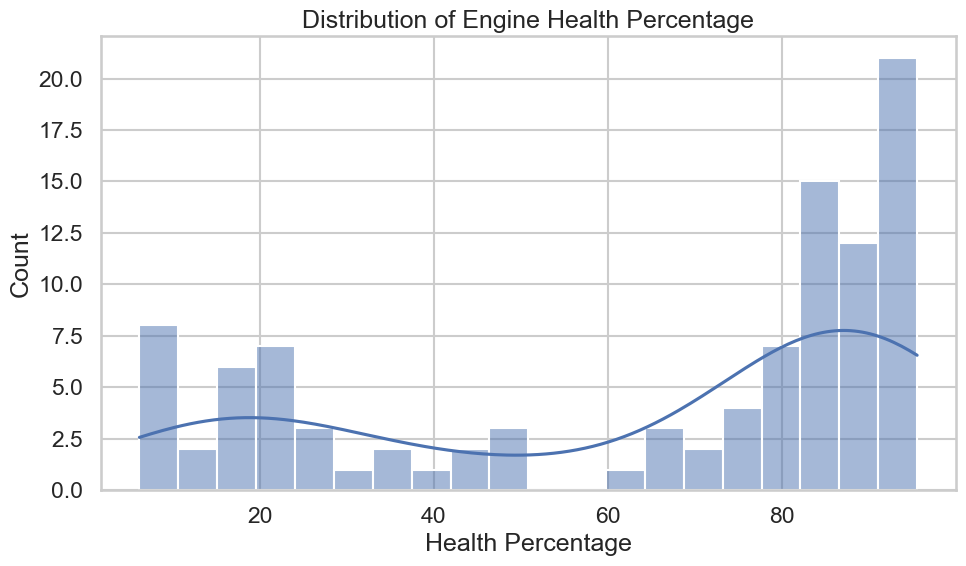

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(health_percent, bins=20, kde=True)

plt.xlabel("Health Percentage")
plt.ylabel("Count")
plt.title("Distribution of Engine Health Percentage")
plt.tight_layout()
plt.show()


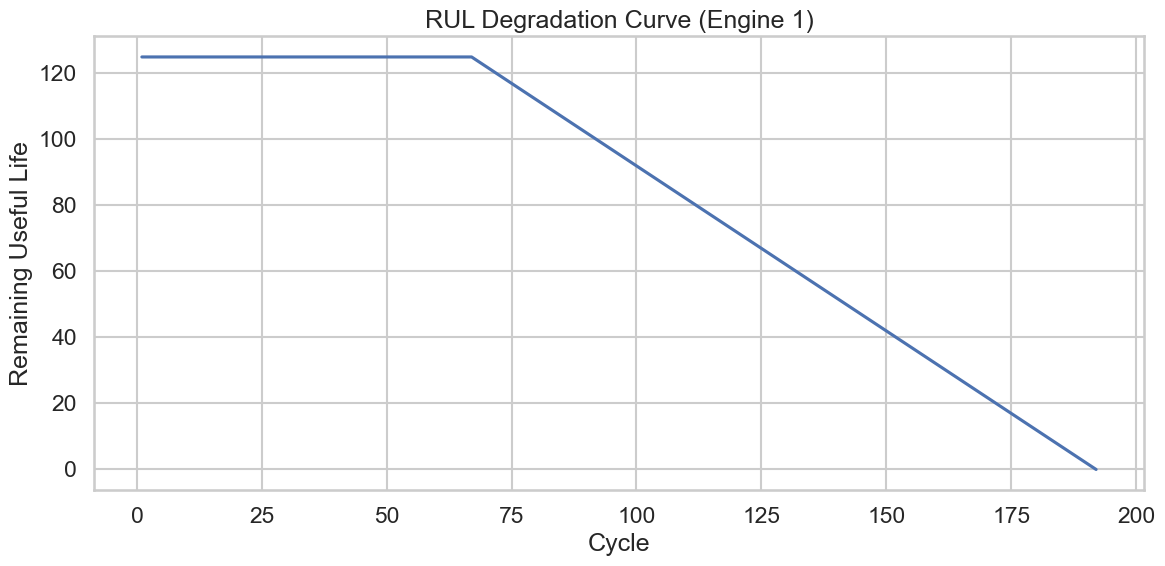

In [28]:
engine_id = 1  # change to any engine ID

engine_data = train_df[train_df["engine_id"] == engine_id]

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data["RUL"]
)

plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.title(f"RUL Degradation Curve (Engine {engine_id})")
plt.tight_layout()
plt.show()



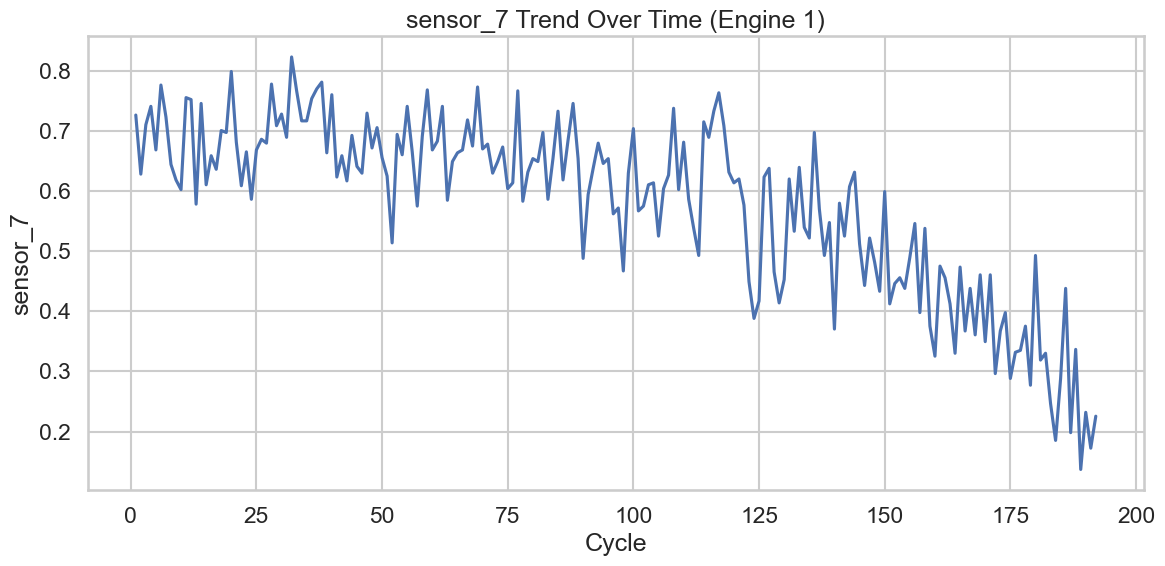

In [29]:
sensor_name = "sensor_7"  # choose any kept sensor

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data[sensor_name]
)

plt.xlabel("Cycle")
plt.ylabel(sensor_name)
plt.title(f"{sensor_name} Trend Over Time (Engine {engine_id})")
plt.tight_layout()
plt.show()
